# Course 4 - Project - Part 2: Data exploration

<a name="top-2"></a>
This notebook is concerned with *Part 2: Data exploration*.

**Contents:**
* [Step 0: Load data](#step-2.0)
* [Step 1: Plot a few images](#step-2.1)
* [Step 2: Make a scree plot](#step-2.2)
* [Step 3: Visualize the features on a 2D-plot](#step-2.3)

## Load data<a name="step-2.0"></a> ([top](#top-2))
---

In [1]:
# Standard library.
import pathlib

# 3rd party.
import numpy as np

# Project.
import utils

We load the training set with the extracted high-level features.

In [2]:
separator = ''.center(80, '-')

path_train = pathlib.Path.cwd() / 'data' / 'swissroads-features-train.npz'
data_train = utils.load(path_train)
print(separator)
print(f'Dataset: train\n{utils.info(data_train)}')

--------------------------------------------------------------------------------
Dataset: train
data: shape=(280, 224, 224, 3), dtype=float32
labels: shape=(280,), dtype=int64
names: shape=(6,), dtype=<U10
features: shape=(280, 1280), dtype=float32


In [3]:
names = data_train['names']  # Same for all data sets.

X_train = data_train['data']
y_train = data_train['labels']
F_train = data_train['features']

## Step 1: Plot a few images<a name="step-2.1"></a> ([top](#top-2))
---

In [4]:
# Standard library.
import typing as T

# 3rd party.
%matplotlib inline
import matplotlib.pyplot as plt

We define a helper function to plot a few images from each category.

In [19]:
def plot_samples(X: np.ndarray, y: np.ndarray, names: np.ndarray,
                 n_samples: T.Optional[int] = 5,
                 cell_width: T.Optional[int] = 1.75,
                 cell_height: T.Optional[int] = 1.75,
                 random_state: T.Optional[int] = None) -> None:
    """\
    Plots a few images from each category in a grid.
    
    Args:
        X: A list of images, as a NumPy array of shape
           ``n [samples] x height [pixels] x width [pixels] x 3 [color channels]``. 
        y: The list of numeric labels of the images, as a Numpy array of shape
           ``n [samples]``.
        names: The list of unique text labels of the images, as a NumPy array of shape
          ``k [categories]``.
        n_samples: The number of images to plot from each category.
        cell_width: The width of a cell.
        cell_height: The height of a cell.
        random_state: The seed for the PRNG.
    """
    if random_state is not None:
        # Make it deterministic.
        np.random.seed(random_state)
    
    nrows = len(names)
    ncols = n_samples
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            figsize=(ncols * cell_width, nrows * cell_height),
                            sharex=True, sharey=True)
    for label in range(len(names)):
        axs_cat = axs[label, :]

        # Randomly choose a few indices of images that belong to this category.
        (idxs,) = np.nonzero(y == label)
        idxs_cat = np.random.choice(idxs, ncols)

        # Display the images.
        for j, (ax_cat, idx_cat) in enumerate(zip(axs_cat, idxs_cat)):
            ax_cat.imshow(X[idx_cat])

            # Add a row header.
            if j == 0:
                ax_cat.set_ylabel(names[label])

            # Add labels.
#             ax_cat.set_xlabel(f'idx: {idx_cat:03d}', fontsize=9)

            # X/y-axis: hide the ticks and their labels.
            ax_cat.tick_params(axis='both', which='both', length=0)
            ax_cat.set_xticklabels([])
            ax_cat.set_yticklabels([])

    fig.tight_layout()
    plt.show()

We plot a few images from each category.

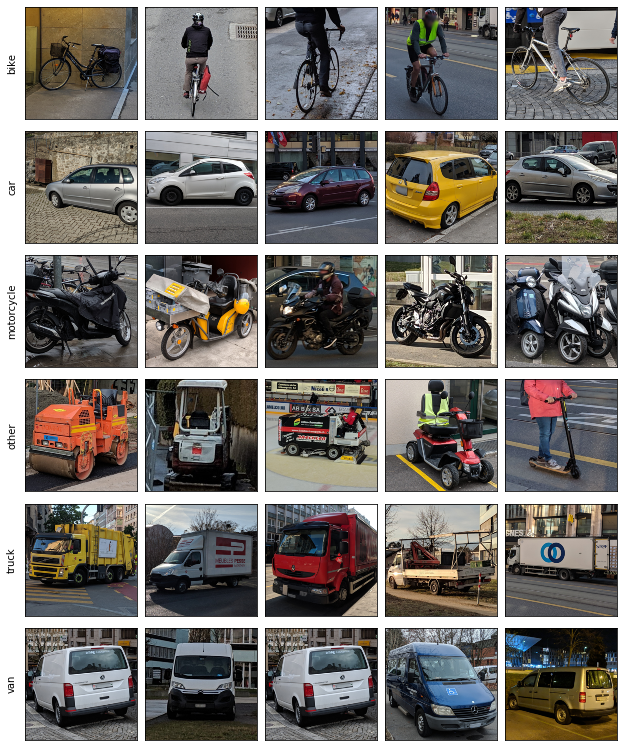

In [20]:
plot_samples(X_train, y_train, names, random_state=0)

## Step 2: Make a scree plot<a name="step-2.2"></a> ([top](#top-2))
---

In [7]:
# 3rd party.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

We define a helper function to make a scree plot.

In [8]:
def plot_scree(pca: PCA,
               n_components: T.Optional[int] = None,
               figsize: T.Optional[T.Tuple[int, int]] = None) -> None:
    """\
    Makes a scree plot.

    Args:
        pca: A fitted PCA object.
        n_components: The optional number of principal components to include in the plot. If 
            omitted, defaults to the actual number of principal components.
        figsize: The optional size of the figure, as a tuple ``(width, height)`` (in inches). If 
            omitted, defaults to the default figure size (see 
            ``matplotlib.rcParams['figure.figsize']``).
    """
    n_components_total = len(pca.components_)
    n_components = n_components if n_components else n_components_total

    # Get the proportion of variance explained.
    pve = pca.explained_variance_ratio_[:n_components]

    # Create a bar plot.
    fig, ax = plt.subplots(figsize=figsize)
    xcor = np.arange(1, n_components + 1)  # 1, 2, ..., n_components
    ax.bar(xcor, pve, width = 0.6)  # Use 40 % for padding.

    # Add the cumulative sum.
    pve_cumsum = np.cumsum(pve)
    ax.step(
        xcor + 0.5, # 1.5, 2.5, ..., (n_components + 0.5)
        pve_cumsum,
        label='cumulative'
    )

    # Add vertical lines.
    ax.vlines(xcor + 0.5, 0.0, pve_cumsum, linestyles='dotted', alpha=0.1)

    # Add labels, legend and tile.
    ax.set_xlabel('principal component')
    ax.set_ylabel('proportion of variance explained')
    ax.legend()
    fig.suptitle(f'Scree plot (principal components: {n_components}/{n_components_total}, '
                 f'PVE: {pve_cumsum[-1] * 100:.2f} %)', y=0.95)

    plt.show()

We define a helper function to plot the minimum number of principal components required to explain given ratios of variance.

In [9]:
def plot_number_of_components_required(pca: PCA, ratios: np.ndarray) -> None:
    """\
    Plots the minimum numbers of principal components required to explain given proportions of
    variance.
    
    Args:
        pca: A fitted PCA object.
        ratios: A list of proportions of variance.
    """
    pve = pca.explained_variance_ratio_
    
    # Make sure the ratios are sorted in ascending order.
    ratios = np.sort(ratios)

    # Get the minimum numbers of principal components required.
    pve_cumsum = np.cumsum(pve)
    npcrs = [(pve_cumsum > ratio).argmax() + 1 for ratio in ratios]
    
    # Most likely due to numerical errors, the cumulative sum does not reach eactly 1.0.
    if ratios[-1] == 1.0:
        npcrs[-1] = len(pca.components_)
    
    # Create a bar plot.
    fig, ax = plt.subplots()
    
    diffs = np.ediff1d(ratios)
    if len(diffs):
        width = diffs.min() * 0.60  # Use 40 % for padding.
        ax.bar(ratios, npcrs, width=width)
    else:
        ax.bar(ratios, npcrs)

    # Annotate with the numbers of principal components required.
    for ratio, npcr in zip(ratios, npcrs):
        ax.annotate(f'{npcr:d}', xy=(ratio, npcr), rotation=0, color="black", ha='center', va='bottom')

    # Add a minor x-tick per ratio.
    ax.set_xticks(ratios, minor=False)
    
    # Add some vertical padding.
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin - 10, ymax + 10)

    # Add labels.
    ax.set_xlabel('proportion of variance explained')
    ax.set_ylabel('number of principal components')
    fig.suptitle(f'Minimum number of principal components required\n'
                 f'to explain given proportions of variance', y=0.98)
    
    plt.show()

We apply PCA on the training set for both the high-level features and the images. We keep all components. In that case, $n_\textrm{components} = \min(n_\textrm{samples}, n_\textrm{features}) = 280$.

In [22]:
# Create a standard scaler.
scaler = StandardScaler()
# Rescale data.
F_train_rescaled = scaler.fit_transform(F_train)

# Create a PCA transformer.
F_train_pca_all = PCA(n_components=None,  # Keep all components.
                      random_state=0)  # Make it deterministic.
# Apply PCA to rescaled data.
F_train_pca_all.fit(F_train_rescaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
# Reshape images as flat arrays.
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))

# Create a standard scaler.
scaler = StandardScaler()
# Rescale data.
X_train_rescaled = scaler.fit_transform(X_train_reshaped)

# Create a PCA transformer.
X_train_pca_all = PCA(n_components=None,  # Keep all components.
                      random_state=0)  # Make it deterministic.
# Apply PCA to rescaled data.
X_train_pca_all.fit(X_train_rescaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

We make plots for the high-level features. (We only include the first 150 principal components in the scree plot since the plot becomes hard to read otherwise.)

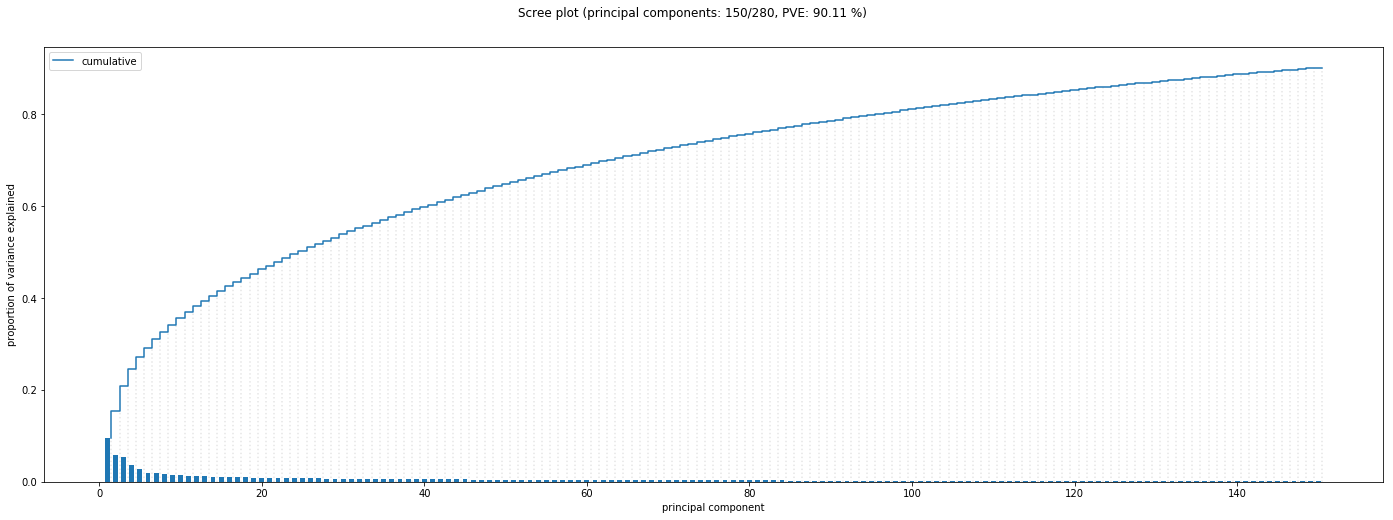

In [12]:
plot_scree(F_train_pca_all, 150, figsize=(24, 8))

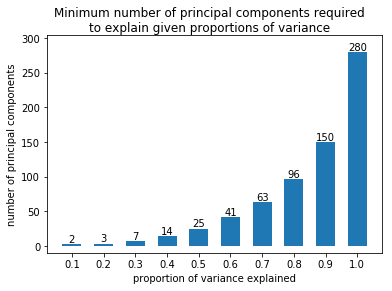

In [13]:
ratios = np.linspace(0.1, 1.0, num=10)  # 0.1, 0.2, ..., 1.0
plot_number_of_components_required(F_train_pca_all, ratios)

We make plots for the images. (Again, we only include the first 150 principal components in the scree plot since the plot becomes hard to read otherwise.)

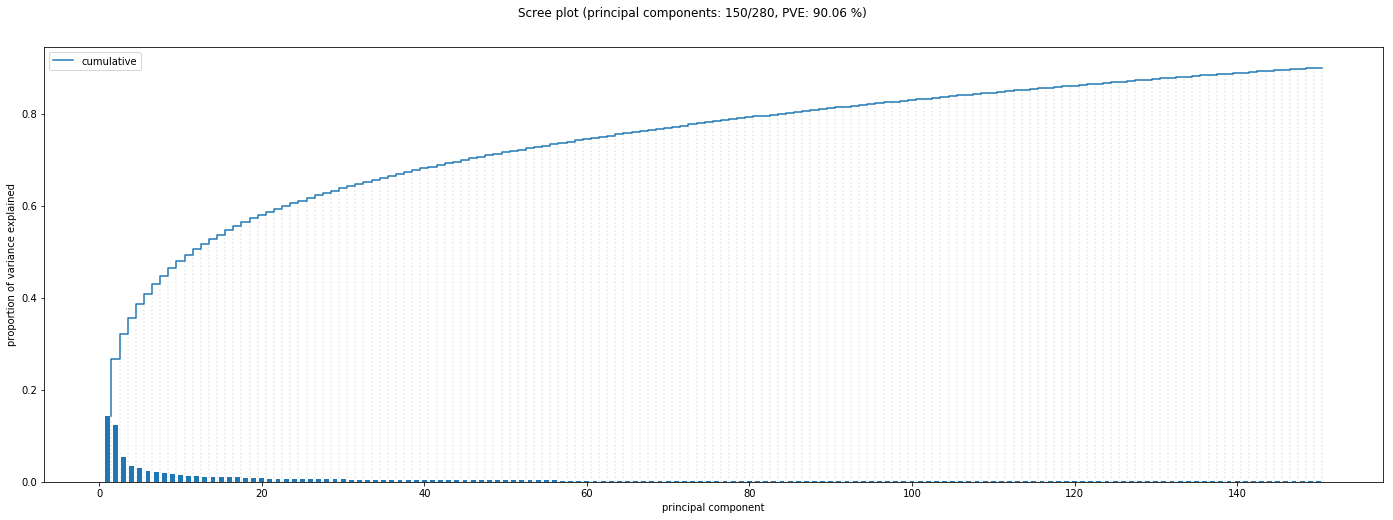

In [14]:
plot_scree(X_train_pca_all, 150, figsize=(24, 8))

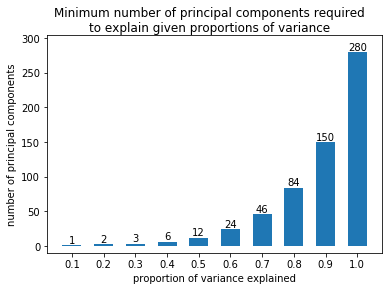

In [15]:
plot_number_of_components_required(X_train_pca_all, ratios)

**Comment:** The plots for the high-level features and for the images are very similar. So as far as PCA is concerned, the extracted high-level features seem to capture well the main features of the images.

## Step 3: Visualize the features on a 2D-plot<a name="step-2.3"></a> ([top](#top-2))
---

We create a PCA with only 2 components (the API does not seem to allow to drop all but the first 2 principal components from `F_pca_all`).

In [16]:
# Create a PCA transformer.
F_train_pca_2d = PCA(n_components=2,  # Keep the first 2 components.
                     random_state=0)  # Make it deterministic.
# Apply PCA to rescaled data.
F_train_2d = F_train_pca_2d.fit_transform(F_train_rescaled)

We define a helper function to make a 2D-plot. We know that the principal components form an orthonormal basis that spans the lower-dimensional space. To project a vector in feature space onto the lower-dimensional space we can simply take the dot product with each principal components. In particular, to project the $i$-th unit vector we can simply take the $i$-th component of each principal component.

In [17]:
def make_2d_plot(X_proj: np.ndarray, y: np.ndarray, names: np.ndarray,
                 figsize: T.Optional[T.Tuple[int, int]] = None) -> None:
    """\
    Plots the projections of all data points onto the 2D space spanned by the first 2 principal
    components. These are orthonormal; we align the x-axis along the  1st one and the y-axis along
    the 2nd one.
    
    Args:
        X_proj: The data points transformed by PCA.
        y: The numeric labels of the data points.
        names: The unique text labels of the data points.
        figsize: The optional size of the figure, as a tuple ``(width, height)`` (in inches). If 
            omitted, defaults to the default figure size (see 
            ``matplotlib.rcParams['figure.figsize']``).
    """    
    # Create a plot.
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot projections of all samples in each category.
    for label in range(len(names)):
        # Get the indices of samples that belong to this category.
        (idxs,) = np.nonzero(y == label)
        # Plot their components.
        ax.scatter(
            X_proj[idxs, 0],
            X_proj[idxs, 1],
            label=f'{names[label]}'
        )

    # Add labels, legend and title.
    ax.set_xlabel('1st component')
    ax.set_ylabel('2nd component')
    ax.legend(bbox_to_anchor=(1.01,1), loc='upper left')
    fig.suptitle(f'PCA: projections by category', y=0.95)
    
    plt.show()

We make a 2D-plot.

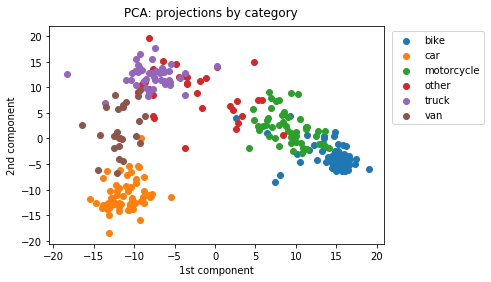

In [18]:
make_2d_plot(F_train_2d, y_train, names)

**Comment:** Using the first 2 principal components, we can already "see" the 6 clusters corresponding the to the 6 categories. Most pairs of clusters overlaps to some extent (*Car-Van*, *Van-Truck* and *Motorcycle-Bike*). Moreover, the *Other* cluter is very spread out and overlaps with many other clusters (*Other-{Van,Truck,Motorcyle}*).